# 必要なライブラリ等をインポート

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("./input"))

['fer2013.csv']


# データを読み込む

In [5]:
data = pd.read_csv('./input/fer2013.csv')
data.shape

(35887, 3)

In [6]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


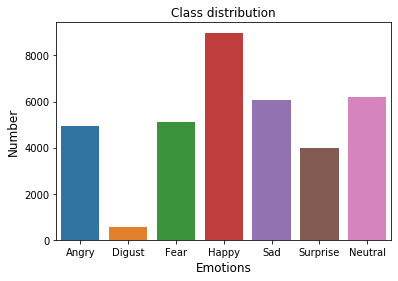

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

##  データの写真をいくつか見てみる

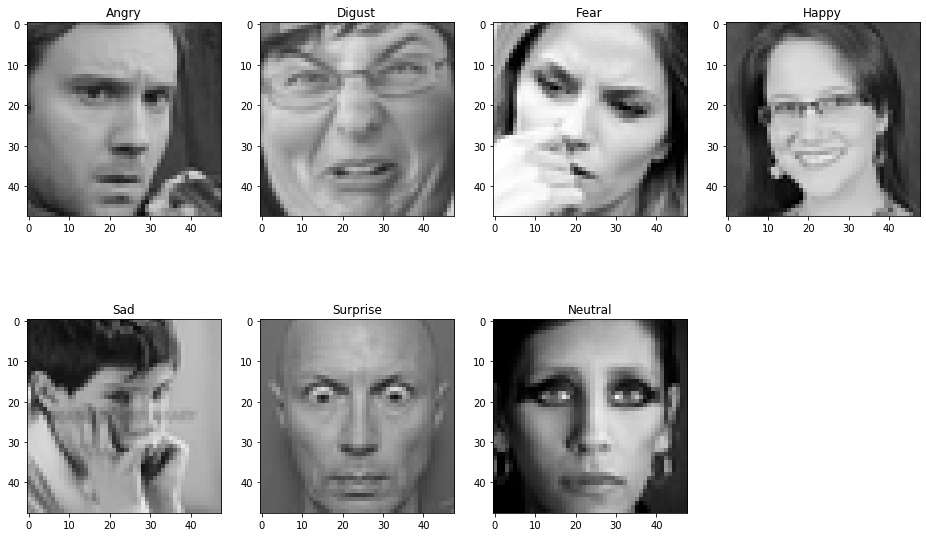

In [10]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

# 学習データとテストデータに分ける

In [11]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


## 学習データとテストデータそれぞれの、感情の分布を見てみる

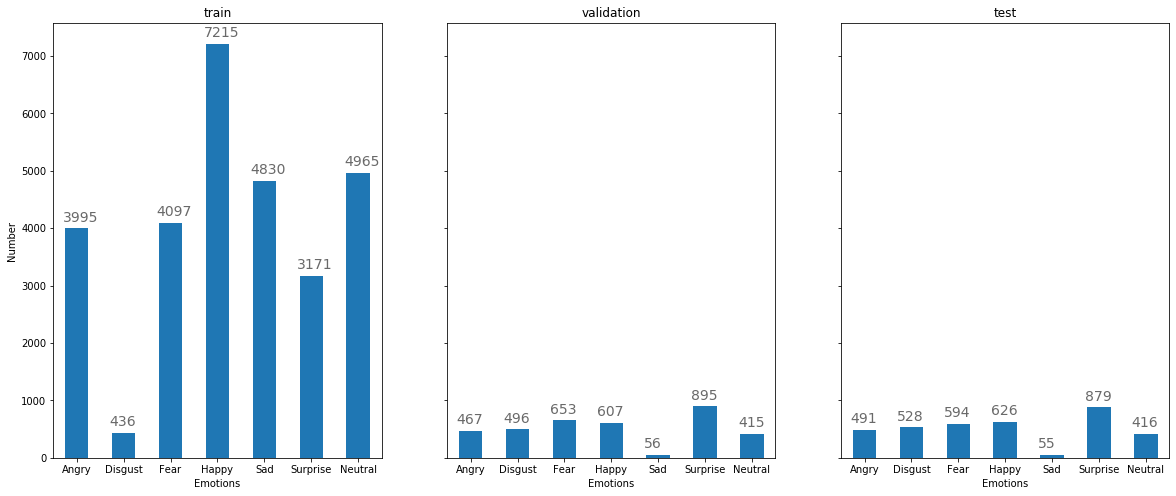

In [12]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()


Notice that the later two subplots share the same y-axis with the first subplot.

The size of train, validation, test are 80%, 10% and 10%, respectively.

The exact number of each class of these datasets are written on top of their x-axis bar.

# モデル生成のためのパラメタ設定

In [14]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [15]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [16]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# CNNモデルの構築

#### CNN Architecture:
- Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
- Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
- Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
- Flatten
- Dense -> BN -> Activation
- Dense -> BN -> Activation
- Dense -> BN -> Activation
- Output layer

In [18]:
model = Sequential()

#### module1

In [20]:
## 畳み込み層
model.add(Conv2D(
        2*2*num_features, 
        kernel_size=(3,3), 
        input_shape=(width, height, 1), 
        data_format='channels_last'
))
model.add(BatchNormalization())
## 活性化関数
model.add(Activation('relu'))
## 畳み込み層
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
## 活性化関数
model.add(Activation('relu'))
## プーリング層
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

### module2

In [21]:
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


## molude3

In [22]:
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

### flatten

In [23]:
model.add(Flatten())

## dense

In [24]:
## dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

### output layer
- ７つの変数に分けるときの活性化関数

In [25]:
model.add(Dense(num_classes, activation='softmax'))

### ハイパーパラメータ
- 損失関数：分類問題はほとんど「categorical_crossentropy」が使われる
- optimizer：「Adam」が一番よく使われる
- metrics：分類問題の場合「accuracy」がほとんど

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
    metrics=['accuracy']
)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
_________

## データの水増し

In [27]:
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=1,
    horizontal_flip=True
)

## early stoppingの設定

In [29]:
es = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    restore_best_weights=True
)

## 学習

In [ ]:
history = model.fit_generator(
    data_generator.flow(train_X, train_Y, batch_size),
    steps_per_epoch=len(train_X)/batch_size,
    epochs=num_epochs,
    verbose=1,
    callbacks=[es],
    validation_data=(val_X, val_Y)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
449/448 [==============================] - 2828s 6s/step - loss: 1.8159 - acc: 0.2490 - val_loss: 1.7346 - val_acc: 0.2976
Epoch 2/50
449/448 [==============================] - 2635s 6s/step - loss: 1.7577 - acc: 0.2743 - val_loss: 1.6765 - val_acc: 0.3394
Epoch 3/50
449/448 [==============================] - 2800s 6s/step - loss: 1.7261 - acc: 0.2988 - val_loss: 1.6394 - val_acc: 0.3371
Epoch 4/50
449/448 [==============================] - 2631s 6s/step - loss: 1.6805 - acc: 0.3209 - val_loss: 1.6900 - val_acc: 0.3522
Epoch 5/50
449/448 [==============================] - 2626s 6s/step - loss: 1.6209 - acc: 0.3522 - val_loss: 1.5248 - val_acc: 0.4185
Epoch 6/50
449/448 [==============================] - 2792s 6s/step - loss: 1.5738 - acc: 0.3763 - val_loss: 1.4111 - val_acc: 0.4511
Epoch 7/50
449/448 [==============================] - 3126s 7s/step - loss: 1.5338 - acc: 0.3924 - val